In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('ncr_ride_bookings.csv')

In [3]:
df.head(5)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23 00:00:00,12:29:38,"""CNR5884300""",Completed,"""CID1982111""",eBike,Palam Vihar,Jhilmil,6.1,45,...,no,no,no,no,no,156,69.5,5,4.2,UPI
1,2024-11-29 00:00:00,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14,...,no,no,no,NaN,Vehicle Breakdown,237,5.73,NaN,no,UPI
2,2024-08-23 00:00:00,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,no,no,no,no,no,627,NaN,4.9,4.9,Debit Card
3,2024-10-21 00:00:00,17:17:25,"""CNR8906825""",No driver found,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,NaN,28.5,...,no,no,no,no,NaN,416,34.02,4.6,5,UPI
4,2024-09-16 00:00:00,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,no,no,no,no,no,737,48.21,4.1,4.3,UPI


In [12]:
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 150047, Columns: 13
Duplicate Rows: 9

Missing Values per Column:
 Date                         7479
Time                         7539
Vehicle Type                 7401
Pickup Location              7480
Drop Location                7777
Avg VTAT                     7373
Avg CTAT                     7575
Cancelled Rides by Driver    7507
Booking Value                7473
Ride Distance                7509
Driver Ratings               7426
Customer Rating              7620
Payment Method               7403
dtype: int64

Data Types:
 object    13
Name: count, dtype: int64


In [14]:
df = df.drop(columns=[
    'Booking ID','Customer ID','Booking Status',
    'Cancelled Rides by Customer','Reason for cancelling by Customer',
    'Driver Cancellation Reason','Incomplete Rides','Incomplete Rides Reason'
], errors='ignore')


In [15]:
#rechecking
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 150047, Columns: 13
Duplicate Rows: 9

Missing Values per Column:
 Date                         7479
Time                         7539
Vehicle Type                 7401
Pickup Location              7480
Drop Location                7777
Avg VTAT                     7373
Avg CTAT                     7575
Cancelled Rides by Driver    7507
Booking Value                7473
Ride Distance                7509
Driver Ratings               7426
Customer Rating              7620
Payment Method               7403
dtype: int64

Data Types:
 object    13
Name: count, dtype: int64


In [16]:
num_cols = [col for col in ["Booking Value", "Ride Distance", "Driver Ratings", "Customer Rating", "Avg VTAT", "Avg CTAT"] if col in df.columns]
cat_cols = [col for col in ["Vehicle Type", "Pickup Location", "Drop Location", "Payment Method"] if col in df.columns]
#text_cols = [col for col in ["Pickup Location", "Drop Location"] if col in df.columns]
# Numeric → convert + fill with median safely
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    if df[col].notnull().sum() > 0:   # only if there are valid numbers
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(0)   # fallback if entire column is NaN

# Categorical → fill with mode safely
for col in cat_cols:
    if df[col].notnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna("Unknown")



# Drop rows with
df = df.dropna(subset=["Cancelled Rides by Driver"])
df = df.dropna(subset=['Date'])
df = df.dropna(subset=['Time'])

# Re-check
print("Remaining rows:", df.shape[0])
print("Empty values \n", df.isnull().sum())


Remaining rows: 128611
Empty values 
 Date                         0
Time                         0
Vehicle Type                 0
Pickup Location              0
Drop Location                0
Avg VTAT                     0
Avg CTAT                     0
Cancelled Rides by Driver    0
Booking Value                0
Ride Distance                0
Driver Ratings               0
Customer Rating              0
Payment Method               0
dtype: int64


In [17]:
# Text preprocessing function
def clean_text(x):
    if pd.isnull(x):
        return "unknown"
    # lowercase
    x = str(x).lower()
    # remove leading/trailing spaces
    x = x.strip()
    # remove special characters except alphanumerics & space
    x = re.sub(r'[^a-z0-9\s]', '', x)
    # normalize whitespace
    x = re.sub(r'\s+', ' ', x)
    return x

# Apply to categorical columns
text_cols = ["Vehicle Type", "Pickup Location", "Drop Location", "Payment Method"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)


In [18]:
#Droping duplicates
df = df.drop_duplicates()

In [19]:
# Function to group rare categories
def group_rare_categories(series, min_freq=1000, other_label="other"):
    value_counts = series.value_counts()
    rare_categories = value_counts[value_counts < min_freq].index
    return series.apply(lambda x: other_label if x in rare_categories else x)

# Apply to text columns after cleaning
for col in text_cols:
    if col in df.columns:
        # Clean first
        df[col] = df[col].apply(clean_text)
        # Group rare categories
        df[col] = group_rare_categories(df[col], min_freq=100, other_label="other")


In [20]:
#rechecking
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 128596, Columns: 13
Duplicate Rows: 0

Missing Values per Column:
 Date                         0
Time                         0
Vehicle Type                 0
Pickup Location              0
Drop Location                0
Avg VTAT                     0
Avg CTAT                     0
Cancelled Rides by Driver    0
Booking Value                0
Ride Distance                0
Driver Ratings               0
Customer Rating              0
Payment Method               0
dtype: int64

Data Types:
 object     7
float64    6
Name: count, dtype: int64


In [21]:
df.head(5)

,Date,Time,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23 00:00:00,12:29:38,ebike,palam vihar,jhilmil,6.1,45.0,no,156.0,69.50,5.0,4.2,upi
1,2024-11-29 00:00:00,18:01:39,go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,no,237.0,5.73,4.3,4.5,upi
2,2024-08-23 00:00:00,08:56:10,auto,khandsa,malviya nagar,13.4,25.8,no,627.0,23.75,4.9,4.9,debit card
3,2024-10-21 00:00:00,17:17:25,premier sedan,central secretariat,inderlok,8.3,28.5,no,416.0,34.02,4.6,5.0,upi
4,2024-09-16 00:00:00,22:08:00,bike,ghitorni village,khan market,5.3,19.6,no,737.0,48.21,4.1,4.3,upi


In [22]:
# Convert target column to binary (0/1)
df["Cancelled Rides by Driver"] = df["Cancelled Rides by Driver"].replace({
    "no": 0,
    "No": 0,
    "NO": 0,
    0: 0,
    "yes": 1,
    "Yes": 1,
    "YES": 1,
    "1": 1
}).astype(int)

# Check conversion
print(df["Cancelled Rides by Driver"].value_counts())


Cancelled Rides by Driver
0    105491
1     23105
Name: count, dtype: int64


C:\Users\Acer\AppData\Local\Temp\ipykernel_26200\2280171177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Cancelled Rides by Driver"] = df["Cancelled Rides by Driver"].replace({


In [23]:
# 1. **Pickup Cancel Rate based on Distance**
#distance_groups = df.groupby('Ride Distance')['Cancelled Rides by Driver'].agg(['sum', 'count'])
#distance_groups['pickup_cancel_rate'] = distance_groups['sum'] / distance_groups['count']

# Merge 'pickup_cancel_rate' back to the original dataframe
#df = df.merge(distance_groups[['pickup_cancel_rate']], on='Ride Distance', how='left')

# 2. **Weekend Flag (is_weekend)**

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['Date'].dt.dayofweek

# Create 'is_weekend' feature (1 for Saturday or Sunday, 0 otherwise)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 3. **Feature Engineering: Date & Time**

# Extract day of week (0 = Monday, 6 = Sunday)
df["day_of_week"] = df["Date"].dt.dayofweek

# Convert Time column to datetime (just the time part)
df["hour_of_day"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour

# Peak hour flag: 7–10 AM or 17–21 PM = 1, else 0
df["peak_hour"] = df["hour_of_day"].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 21) else 0)

# Drop raw Date and Time (not needed anymore)
df = df.drop(columns=["Date", "Time"])

# Check new columns
print(df[["day_of_week", "hour_of_day", "peak_hour", "is_weekend"]].head())



C:\Users\Acer\AppData\Local\Temp\ipykernel_26200\519812565.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour_of_day"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour


   day_of_week  hour_of_day  peak_hour  is_weekend
0            5           12          0           1
1            4           18          1           0
2            4            8          1           0
3            0           17          1           0
4            0           22          0           0


In [24]:
df.head(5)

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_of_week,is_weekend,hour_of_day,peak_hour
0,ebike,palam vihar,jhilmil,6.1,45.0,0,156.0,69.50,5.0,4.2,upi,5,1,12,0
1,go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,0,237.0,5.73,4.3,4.5,upi,4,0,18,1
2,auto,khandsa,malviya nagar,13.4,25.8,0,627.0,23.75,4.9,4.9,debit card,4,0,8,1
3,premier sedan,central secretariat,inderlok,8.3,28.5,0,416.0,34.02,4.6,5.0,upi,0,0,17,1
4,bike,ghitorni village,khan market,5.3,19.6,0,737.0,48.21,4.1,4.3,upi,0,0,22,0


In [25]:
def cap_outliers(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return np.where(series < lower, lower, np.where(series > upper, upper, series))


for col in num_cols:
    df[col] = cap_outliers(df[col])


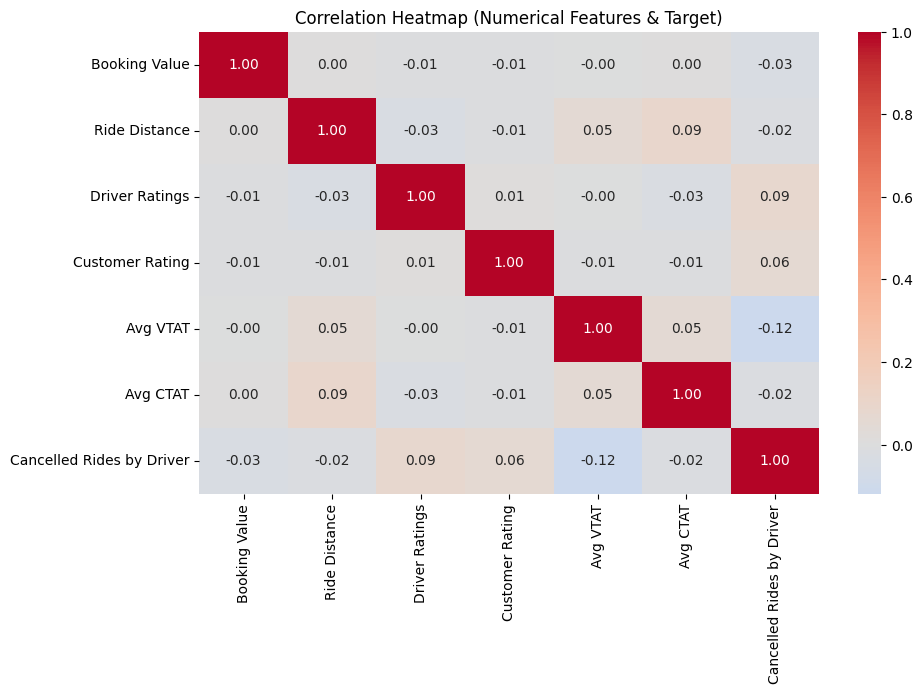

Correlation with target (Cancelled Rides by Driver):
 Cancelled Rides by Driver    1.000000
Driver Ratings               0.085570
Customer Rating              0.057456
Avg CTAT                    -0.016621
Ride Distance               -0.021024
Booking Value               -0.034757
Avg VTAT                    -0.119318
Name: Cancelled Rides by Driver, dtype: float64


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for numerical features + target
corr_matrix = df[num_cols + ["Cancelled Rides by Driver"]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features & Target)")
plt.show()

# Correlation values of each feature with target
target_corr = corr_matrix["Cancelled Rides by Driver"].sort_values(ascending=False)
print("Correlation with target (Cancelled Rides by Driver):\n", target_corr)


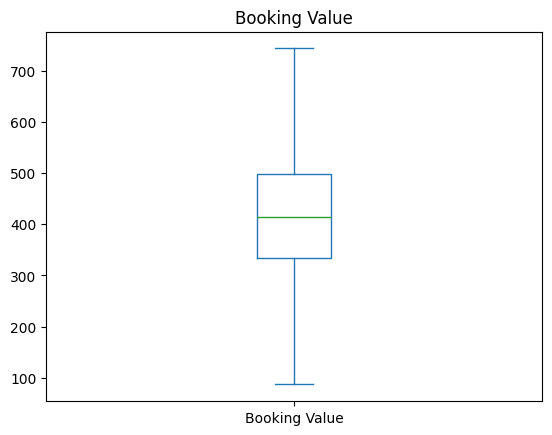

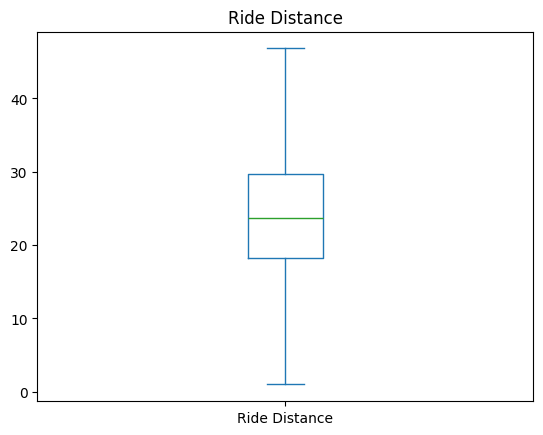

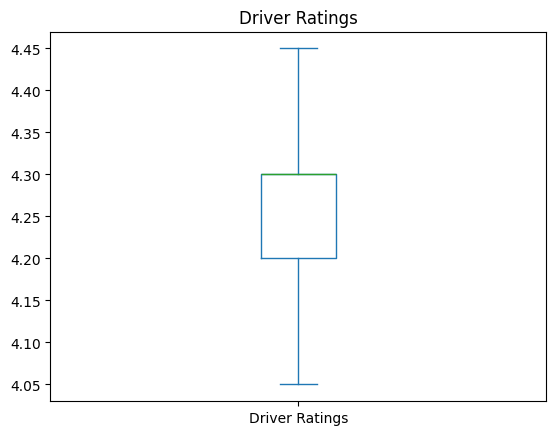

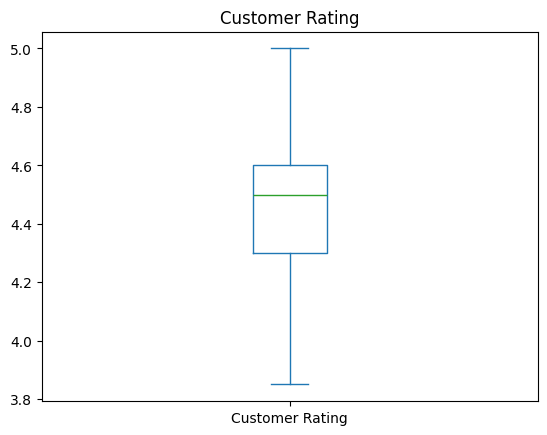

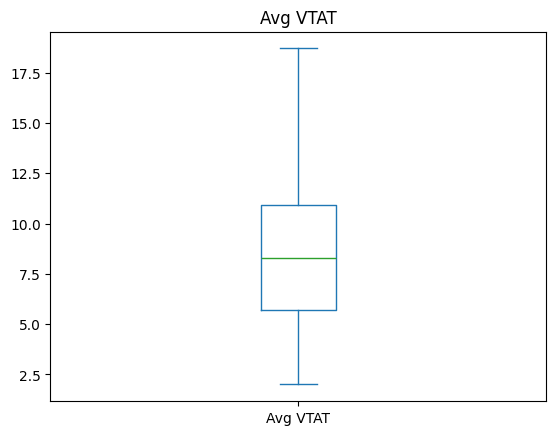

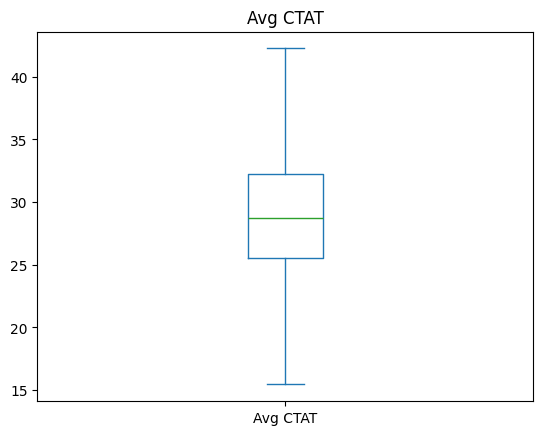

In [29]:
for col in num_cols:
    plt.figure()
    df[col].plot(kind="box", title=col)
    plt.show()

In [30]:
df.head(5)

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_of_week,is_weekend,hour_of_day,peak_hour
0,ebike,palam vihar,jhilmil,6.1,42.25,0,156.0,46.805,4.45,4.2,upi,5,1,12,0
1,go sedan,shastri nagar,gurgaon sector 56,4.9,15.45,0,237.0,5.730,4.30,4.5,upi,4,0,18,1
2,auto,khandsa,malviya nagar,13.4,25.80,0,627.0,23.750,4.45,4.9,debit card,4,0,8,1
3,premier sedan,central secretariat,inderlok,8.3,28.50,0,416.0,34.020,4.45,5.0,upi,0,0,17,1
4,bike,ghitorni village,khan market,5.3,19.60,0,737.0,46.805,4.10,4.3,upi,0,0,22,0


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [32]:
X = df.drop("Cancelled Rides by Driver", axis =1)
y = df["Cancelled Rides by Driver"]

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb


preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

chi2_selector = SelectKBest(chi2, k='all')

In [37]:
ratio_of_minority_class_to_majority_class = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [38]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ),
    "Gradient Boosting": xgb.XGBClassifier(
          n_estimators=200,
          learning_rate=0.05,
          max_depth=5,
          subsample=0.8,
          random_state=42,
          scale_pos_weight=ratio_of_minority_class_to_majority_class

    )
}



In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

# 1. Train models & store results

results_summary = {}
conf_matrices = {}
roc_curves = {}
pr_curves = {}

# Train each model and evaluate
for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor),
      ("feature_selector", chi2_selector),
      ("classifier", model)])

    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    ap = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

    results_summary[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": auc,
        "PR-AUC": ap
    }

    # Confusion Matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr)

    # PR curve
    if y_proba is not None:
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        pr_curves[name] = (rec, prec)

    # Save models
    if name == "Gradient Boosting":
        joblib.dump(clf, 'gradient_boosting_model_pipeline.pkl')
        print(f"Gradient Boosting model saved successfully!")

    elif name == "Decision Tree":
        joblib.dump(clf, 'D_T_model_pipeline.pkl')
        print(f"Decision Tree model saved successfully!")
    elif name == "Logistic Regression":
        joblib.dump(clf, 'Logistic_Regression_pipeline.pkl')
        print(f"Logistic Regression model saved successfully!")
    elif name == "Random Forest":
        joblib.dump(clf, 'Random_Forest_pipeline.pkl')
        print(f"Random Forest model saved successfully!")

Logistic Regression model saved successfully!
Decision Tree model saved successfully!
Random Forest model saved successfully!
Gradient Boosting model saved successfully!


===== Results Summary (with ranking) =====


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Accuracy_Rank,Precision_Rank,Recall_Rank,F1_Rank,ROC-AUC_Rank,PR-AUC_Rank
Logistic Regression,0.863919,0.567971,0.999783,0.724409,0.933760,0.664554,4.0,4.0,2.0,4.0,4.0,4.0
Decision Tree,0.959292,0.847070,0.942621,0.892295,0.979356,0.845296,1.0,1.0,4.0,1.0,2.0,2.0
Random Forest,0.870218,0.579544,1.000000,0.733812,0.970729,0.828198,3.0,3.0,1.0,3.0,3.0,3.0
Gradient Boosting,0.959215,0.846604,0.942839,0.892134,0.982453,0.901372,2.0,2.0,3.0,2.0,1.0,1.0



===== Best Models per Metric =====
Accuracy: Decision Tree (0.959)
Precision: Decision Tree (0.847)
Recall: Random Forest (1.000)
F1: Decision Tree (0.892)
ROC-AUC: Gradient Boosting (0.982)
PR-AUC: Gradient Boosting (0.901)


C:\Users\Acer\AppData\Local\Temp\ipykernel_26200\3277514140.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="Blues_d")


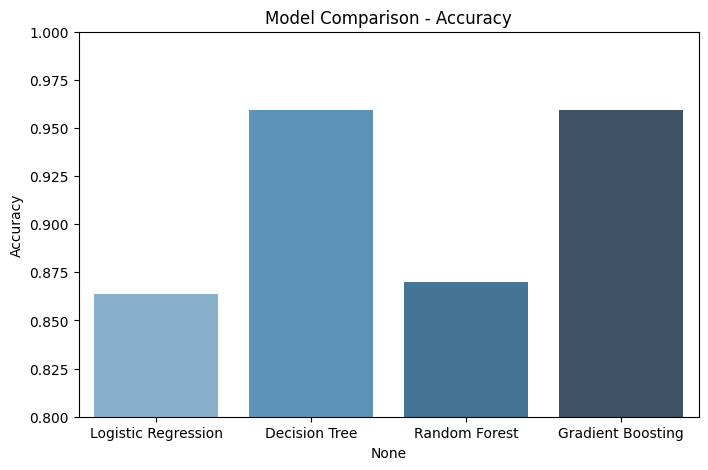

C:\Users\Acer\AppData\Local\Temp\ipykernel_26200\3277514140.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["F1"], palette="Greens_d")


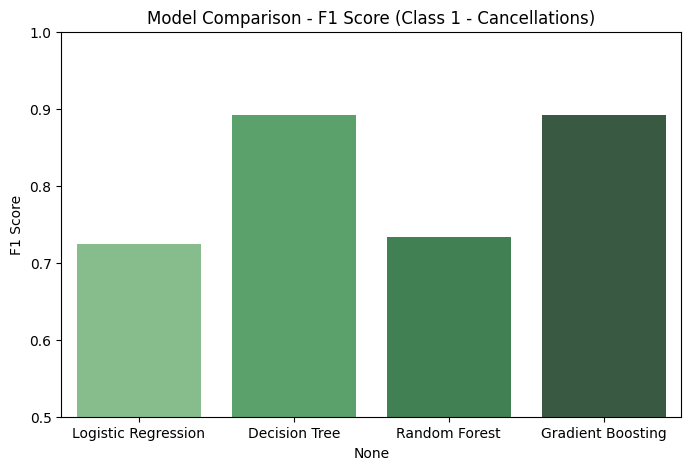

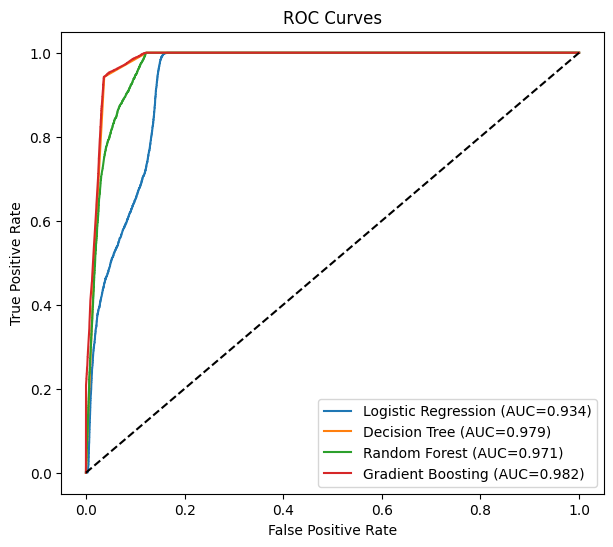

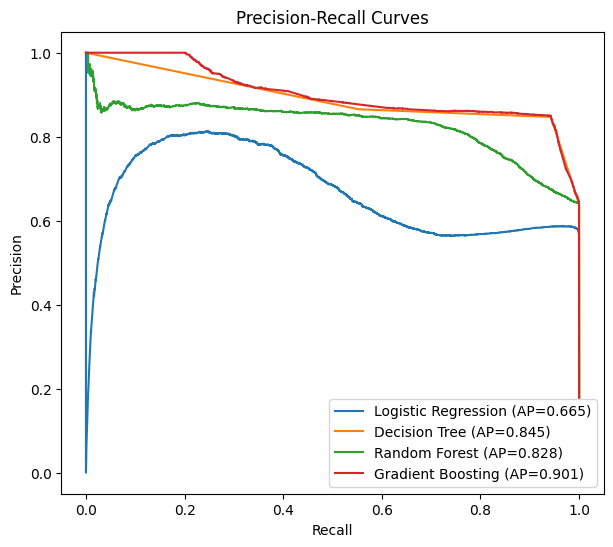

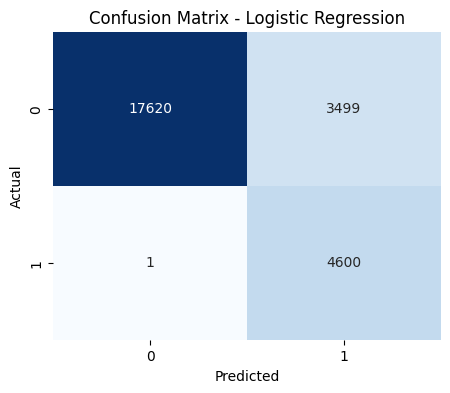

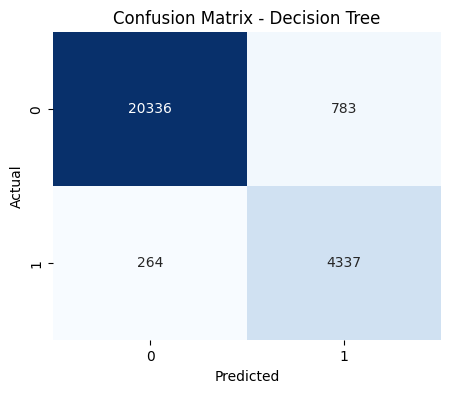

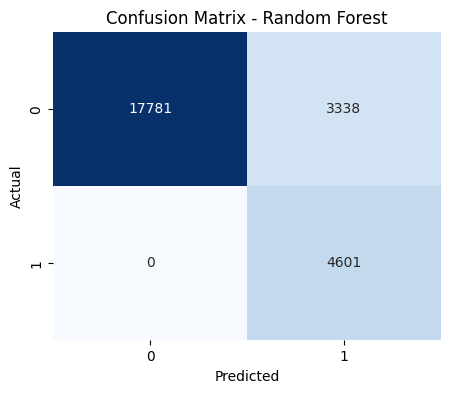

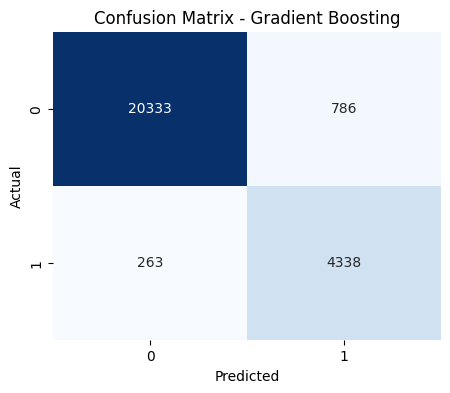

In [41]:
# 2. Results Table
results_df = pd.DataFrame(results_summary).T

# Add rank columns (lower rank = better)
ranked_df = results_df.copy()
for col in results_df.columns:
    ranked_df[col+"_Rank"] = results_df[col].rank(ascending=False)

# Highlight best model for each metric
best_models = {}
for col in results_df.columns:
    best_models[col] = results_df[col].idxmax()

print("===== Results Summary (with ranking) =====")
display(ranked_df)

print("\n===== Best Models per Metric =====")
for metric, model in best_models.items():
    print(f"{metric}: {model} ({results_df.loc[model, metric]:.3f})")


# 3. Accuracy & F1 Bar Charts

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="Blues_d")
plt.title("Model Comparison - Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["F1"], palette="Greens_d")
plt.title("Model Comparison - F1 Score (Class 1 - Cancellations)")
plt.ylabel("F1 Score")
plt.ylim(0.5, 1.0)
plt.show()


# 4. ROC Curves

plt.figure(figsize=(7,6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results_summary[name]['ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# 5. Precision-Recall Curves

plt.figure(figsize=(7,6))
for name, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=f"{name} (AP={results_summary[name]['PR-AUC']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


# 6. Confusion Matrices (Optional display)

for name, cm in conf_matrices.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [50]:
import os
import joblib

def load_model(model_name, folder="models"):
    path = os.path.join(folder, model_name)
    return joblib.load(path)

# Load the saved D_Tl model pipeline
loaded_model = load_model("D_T_model_pipeline.pkl",folder="saved_models")

# Save the full pipeline (model + preprocessing steps)
joblib.dump(loaded_model, 'D_T_model_pipeline.pkll')
print("Model pipeline loaded as D_T_model_pipeline.pkl")

# Example user input (ensure it matches the training data structure)
user_input = {

    "Booking Value": 414.0,
    "Ride Distance": 23.75,
    "Driver Ratings": 4.30,
    "Vehicle Type": "go sedan",         # From the dataset
    "Pickup Location": "manesar",       # Example pickup location from dataset
    "Drop Location": "badshahpur",
    "Payment Method": "no",
    "day_of_week": 5,                   # Friday
    "is_weekend": 1,
    "hour_of_day": 18,
    "peak_hour": 1,
    "Avg VTAT": 9.0,
    "Avg CTAT" :28.70,
    "Customer Rating" : 4.5
}
# Convert user input to DataFrame
user_df = pd.DataFrame([user_input])

# Use the entire pipeline (which includes preprocessing and prediction)
prediction = loaded_model.predict(user_df)[0]
prob = loaded_model.predict_proba(user_df)[0][1] # Probability for cancelled class (1)

# Set a custom threshold (e.g., 0.4)
#threshold = 0.4

# Apply the threshold to make the final prediction
#prediction = 1 if prob > threshold else 0

# Output the result with the threshold applied
if prediction == 1:
    print(f"❌ The ride is likely cancelled (prob: {prob:.2f})")
else:
    print(f"✅ The ride is not cancelled (prob: {1 - prob:.2f})")

# Display probability calculation for better understanding
print(f"Calculated probability of cancellation: {prob:.2f}")
#print(f"Threshold applied: {threshold}")
print(f"Prediction: {'Cancelled' if prediction == 1 else 'Not Cancelled'}")


Model pipeline loaded as D_T_model_pipeline.pkl
❌ The ride is likely cancelled (prob: 0.95)
Calculated probability of cancellation: 0.95
Prediction: Cancelled


In [51]:
X_val

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_of_week,is_weekend,hour_of_day,peak_hour
55042,auto,udyog vihar phase 4,pulbangash,6.5,28.70,414.0,23.75,4.30,4.5,no,1,0,10,1
87394,go sedan,manesar,badshahpur,9.0,28.70,414.0,23.75,4.30,4.5,no,5,1,18,1
35537,auto,connaught place,rohini east,9.0,34.20,140.0,5.42,4.45,4.6,credit card,0,0,9,1
57772,auto,khan market,iffco chowk,3.4,28.70,414.0,23.75,4.30,4.5,no,0,0,16,0
45803,go sedan,kanhaiya nagar,green park,6.6,28.70,414.0,23.75,4.30,4.5,no,6,1,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65219,auto,keshav puram,rohini west,4.3,42.25,570.0,20.19,4.45,4.4,upi,2,0,10,1
104202,go sedan,rohini,,4.5,28.70,414.0,23.75,4.30,4.5,no,6,1,19,1
5410,go sedan,cyber hub,karkarduma,9.1,25.40,408.0,45.14,4.45,4.1,uber wallet,0,0,3,0
33487,bike,noida sector 18,,4.2,28.70,414.0,23.75,4.30,4.5,no,1,0,21,1


In [52]:
y_val

55042     0
87394     1
35537     0
57772     1
45803     1
         ..
65219     0
104202    1
5410      0
33487     1
137294    0
Name: Cancelled Rides by Driver, Length: 25719, dtype: int64